# GAN MODEL TRAINING
---

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from helpers import find_missing_date_ranges
from gan import SolarGAN
from enums import (
    DatasetColumns,
    WeatherDatasetColumns
)

from sklearn.preprocessing import MinMaxScaler

## Data Preparation
---


In [3]:
# Load data
FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"

original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

In [4]:
# Find missing date ranges
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)
gap_dates = pd.date_range(start=gap_start, end=gap_end, freq="h")

In [5]:
# Data Splitting
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
post_gap_data = original_data[original_data.index >= gap_end].asfreq("h")

pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[:pre_gap_train_size].copy()
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]

pre_gap_train.loc[:, DatasetColumns.PV_YIELD.value] = pre_gap_train[
    DatasetColumns.PV_YIELD.value
].interpolate(method="linear")


pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
pre_weather_data = pre_weather_data.reindex(pre_gap_data.index)
pre_weather_data_test = pre_weather_data.reindex(pre_gap_test.index)


gap_weather_data = weather_data.reindex(gap_dates).ffill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()

pre_gap_train_combined = pre_gap_train.join(
    pre_weather_data[weather_features], how="inner"
)
pre_gap_test_combined = pre_gap_test.join(
    pre_weather_data_test[weather_features], how="inner"
)

## GAN Setup
---

In [6]:
# GAN Hyperparameters
LATENT_DIM = 128
LEARNING_RATE = 5e-5
BATCH_SIZE = 64 
EPOCHS = 1000

In [7]:
# Prepare Data
def prepare_data(pre_gap_train_combined, pre_gap_test_combined, weather_features):
    combined_columns = [DatasetColumns.PV_YIELD.value] + weather_features
    scaler = MinMaxScaler()

    train_scaled = scaler.fit_transform(pre_gap_train_combined[combined_columns])
    train_pv = train_scaled[:, 0:1].astype(np.float32)  
    train_weather = train_scaled[:, 1:].astype(np.float32)  
    
    test_scaled = scaler.transform(pre_gap_test_combined[combined_columns])
    test_pv = test_scaled[:, 0:1].astype(np.float32)
    test_weather = test_scaled[:, 1:].astype(np.float32)
        
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(train_pv, tf.float32), tf.cast(train_weather, tf.float32))
    )
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE)
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (tf.cast(test_pv, tf.float32), tf.cast(test_weather, tf.float32))
    )
    test_dataset = test_dataset.batch(BATCH_SIZE)

    return train_dataset, test_dataset, scaler

In [8]:
# Train Solar GAN
def train_solar_gan(train_dataset, num_features):
    solar_gan = SolarGAN(LATENT_DIM, num_features)    
    solar_gan.compile(
        g_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9),
        d_optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, beta_1=0.5, beta_2=0.9)
    )
    
    history = {"d_loss": [], "g_loss": []}
    best_loss = float("inf")
    patience = 50
    patience_counter = 0
    min_epochs = 100  # Ensure minimum training time
    
    for epoch in range(EPOCHS):
        d_losses = []
        g_losses = []
        
        for batch_data in train_dataset:
            losses = solar_gan.train_step(batch_data)
            d_losses.append(float(losses["d_loss"]))
            g_losses.append(float(losses["g_loss"]))
        
        avg_d_loss = np.mean(d_losses)
        avg_g_loss = np.mean(g_losses)
        history["d_loss"].append(avg_d_loss)
        history["g_loss"].append(avg_g_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{EPOCHS}")
            print(f"D Loss: {avg_d_loss:.4f} | G Loss: {avg_g_loss:.4f}")
        
        # More sophisticated early stopping
        if epoch >= min_epochs:
            current_loss = abs(avg_d_loss) + abs(avg_g_loss)
            if current_loss < best_loss * 0.995:  # Require 0.5% improvement
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
            
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}")
                break
    
    return solar_gan, history

In [9]:
# Visualize training progress
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.plot(history["d_loss"], label="Discriminator Loss")
    plt.plot(history["g_loss"], label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training History")
    plt.grid(True)
    plt.show()

In [21]:
# Evaluate Model
def generate_predictions(model, weather_features, scaler):
    weather_features = tf.cast(weather_features, tf.float32)
    batch_size = tf.shape(weather_features)[0]

    noise = tf.random.normal([batch_size, LATENT_DIM], dtype=tf.float32)    
    predictions_scaled = model.generator([noise, weather_features], training=False)

    predictions_with_weather = np.concatenate(
        [predictions_scaled.numpy(), weather_features.numpy()], axis=1
    )
    predictions = scaler.inverse_transform(predictions_with_weather)[:, 0]

    return predictions

def evaluate_model(model, test_dataset, scaler):
    all_predictions = []
    all_true_values = []

    for test_pv, test_weather in test_dataset:
        batch_predictions = generate_predictions(model, test_weather, scaler)
        all_predictions.extend(batch_predictions)
        all_true_values.extend(test_pv.numpy().flatten())

    all_predictions = np.array(all_predictions)
    all_true_values = np.array(all_true_values)
    
    mse = np.mean((all_predictions - all_true_values) ** 2)
    mae = np.mean(np.abs(all_predictions - all_true_values))

    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae:.4f}")

    return all_predictions, all_true_values

## `pre_gap_data` training model
---

In [11]:
# Prepare PRE-GAP train and test data
train_dataset, test_dataset, scaler = prepare_data(
    pre_gap_train_combined,
    pre_gap_test_combined,
    weather_features
)

/Users/richie/.venv/dev/lib/python3.12/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
2025-02-06 17:46:47.266992: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-06 17:46:49.160437: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-06 17:46:53.792094: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-06 17:47:03.468348: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10/1000
D Loss: 3.8792 | G Loss: 0.0529


2025-02-06 17:47:22.748337: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 20/1000
D Loss: 3.8966 | G Loss: 0.0318
Epoch 30/1000
D Loss: 3.8092 | G Loss: 0.0103


2025-02-06 17:48:01.389681: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 40/1000
D Loss: 3.8625 | G Loss: 0.0218
Epoch 50/1000
D Loss: 3.9279 | G Loss: 0.0227
Epoch 60/1000
D Loss: 3.8876 | G Loss: 0.0389


2025-02-06 17:49:21.697534: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 70/1000
D Loss: 3.8730 | G Loss: 0.0367
Epoch 80/1000
D Loss: 3.7481 | G Loss: 0.0069
Epoch 90/1000
D Loss: 3.8788 | G Loss: 0.0225
Epoch 100/1000
D Loss: 3.8665 | G Loss: 0.0009
Epoch 110/1000
D Loss: 3.6676 | G Loss: -0.0008
Epoch 120/1000
D Loss: 3.4823 | G Loss: 0.0194


2025-02-06 17:52:10.734718: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 130/1000
D Loss: 3.3099 | G Loss: 0.0056
Epoch 140/1000
D Loss: 3.2665 | G Loss: 0.0044
Epoch 150/1000
D Loss: 3.1859 | G Loss: 0.0221
Epoch 160/1000
D Loss: 3.1605 | G Loss: 0.0261
Epoch 170/1000
D Loss: 3.1303 | G Loss: 0.0283
Epoch 180/1000
D Loss: 3.0535 | G Loss: 0.0275
Epoch 190/1000
D Loss: 3.1407 | G Loss: 0.0243
Epoch 200/1000
D Loss: 3.1058 | G Loss: 0.0334
Epoch 210/1000
D Loss: 3.1042 | G Loss: 0.0083
Epoch 220/1000
D Loss: 3.1503 | G Loss: 0.0230
Epoch 230/1000
D Loss: 3.1616 | G Loss: 0.0230
Epoch 240/1000
D Loss: 3.0656 | G Loss: 0.0067
Epoch 250/1000
D Loss: 3.0119 | G Loss: 0.0180


2025-02-06 17:57:33.906245: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 260/1000
D Loss: 2.9678 | G Loss: 0.0061
Early stopping triggered at epoch 269


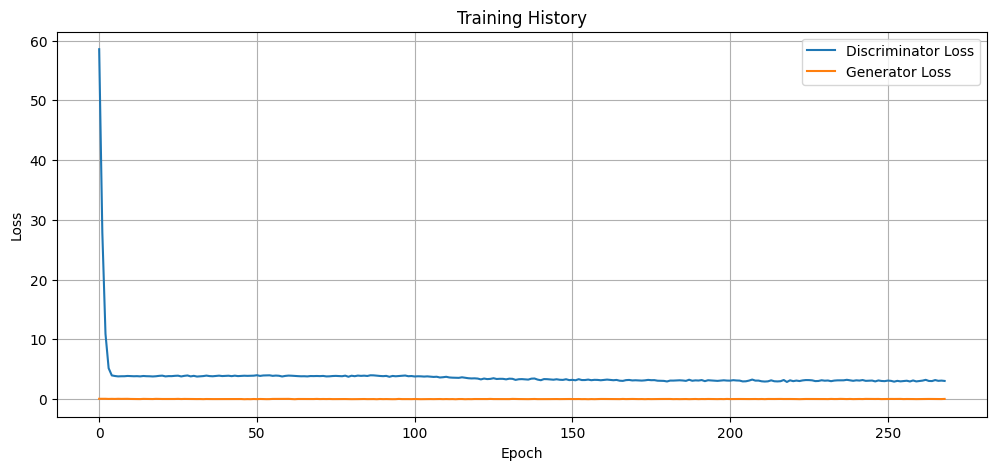

In [12]:
# Train the model
num_weather_features = len(weather_features)
solar_gan, history = train_solar_gan(train_dataset, num_weather_features)
plot_training_history(history)

Mean Squared Error: nan
Mean Absolute Error: nan


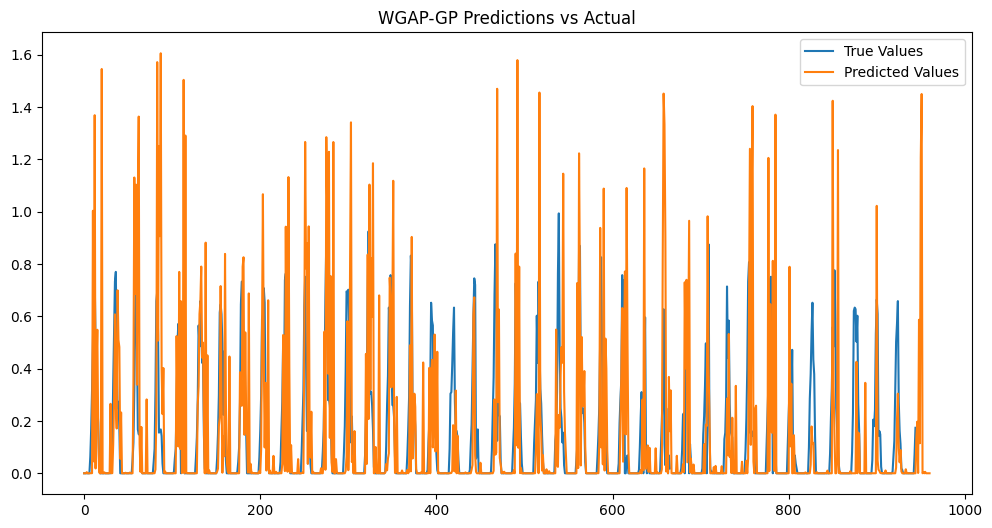

In [23]:
# Evaluating model on test set
predictions, true_values = evaluate_model(solar_gan, test_dataset, scaler)

plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.legend()
plt.title('WGAP-GP Predictions vs Actual')
plt.show()